# Import necessary modules

In [1]:
!pip install -U imbalanced-learn
!pip install gensim

# Standard libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

# Processing
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
from imblearn.under_sampling import RandomUnderSampler

# gensim
import gensim
from gensim.models import Word2Vec

# nltk
from nltk import sent_tokenize, word_tokenize

# Metrics
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, roc_auc_score, \
        f1_score, precision_score, recall_score

# Classifiers
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

# Neural networks
from keras.models import Sequential, load_model
from keras.layers import Dense, Flatten
from keras.initializers import Constant
from keras.callbacks import Callback, EarlyStopping, ModelCheckpoint
from keras.utils import plot_model

Requirement already up-to-date: imbalanced-learn in /opt/conda/lib/python3.6/site-packages (0.7.0)


Using TensorFlow backend.


# Handle Imbalanced Dataset

## Exploratory Data Analysis

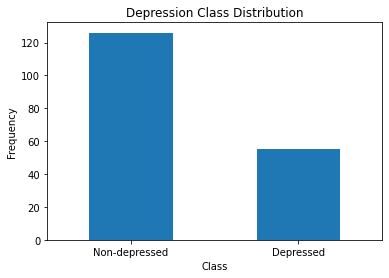

The ratio of negative to positive cases is 2.29.


In [2]:
df = pd.read_csv("../../data/clean_compiled_transcripts.csv")

count_classes = pd.value_counts(df.PHQ_Binary)
count_classes.plot(kind = 'bar', rot=0)
labels = ["Non-depressed", "Depressed"]

plt.title("Depression Class Distribution")
plt.xticks(range(2), labels)
plt.xlabel("Class")
plt.ylabel("Frequency")
plt.show()

print(f"The ratio of negative to positive cases is {round(count_classes[0] / count_classes[1], 2)}.")

Clearly, the dataset is highly imbalanced and is likely to result in poor performance. We should strive for 50:50 during training.

## Load pretrained vector embeddings

In [3]:
if not Path('./GoogleNews-vectors-negative300.bin.gz').exists():
    !wget -P ./ "https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz"

--2020-11-11 12:44:40--  https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.216.106.238
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.216.106.238|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1647046227 (1.5G) [application/x-gzip]
Saving to: ‘./GoogleNews-vectors-negative300.bin.gz’

GoogleNews-vectors- 100%[===================>]   1.53G  12.5MB/s    in 2m 24s  

2020-11-11 12:47:05 (10.9 MB/s) - ‘./GoogleNews-vectors-negative300.bin.gz’ saved [1647046227/1647046227]



In [4]:
%%time

wv = gensim.models.KeyedVectors.load_word2vec_format("GoogleNews-vectors-negative300.bin.gz", 
                                                     binary=True)
wv.init_sims(replace=True)
print('Model loaded')

Model loaded
CPU times: user 49.1 s, sys: 5.19 s, total: 54.3 s
Wall time: 56.4 s


In [5]:
# averaging the word vectors per document

def word_averaging(wv, words):
    all_words, mean = set(), []
    
    # for each word in the list of words
    for word in words:
        # if the words are already vectors, then just append them
        if isinstance(word, np.ndarray):
            mean.append(word)
        # if not: first get the vector embedding for the words
        elif word in wv.vocab:
            mean.append(wv.syn0norm[wv.vocab[word].index])
            all_words.add(wv.vocab[word].index)

    if not mean:
        # error handling in case mean cannot be calculated
        logging.warning("cannot compute similarity with no input %s", words)
        return np.zeros(wv.vector_size,)

    # use gensim's method to calculate the mean of all the words appended to mean list
    mean = gensim.matutils.unitvec(np.array(mean).mean(axis=0)).astype(np.float32)
    return mean

def word_averaging_list(wv, text_list):
    return np.vstack([word_averaging(wv, post) for post in text_list ])

## Tokenization 

In [6]:
def w2v_tokenize_text(text):
    # create tokens, a list of words, for each post. This function will do some cleaning based on English language
    tokens = []
    for sent in sent_tokenize(text, language='english'):
        for word in word_tokenize(sent, language='english'):
            if len(word) < 2:
                continue
            tokens.append(word)
    return tokens

tokenized = df.apply(lambda r: w2v_tokenize_text(r['Transcript']), axis=1).values

## Split the dataset 

In [7]:
RANDOM_STATE = 42 # lucky number

X = word_averaging_list(wv, tokenized)
y = df.PHQ_Binary

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:13: DeprecationWarning: Call to deprecated `syn0norm` (Attribute will be removed in 4.0.0, use self.vectors_norm instead).
  del sys.path[0]


In [8]:
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_STATE)

X_train_val.shape, X_test.shape

((144, 300), (37, 300))

### Undersampling
We will be using undersampling techniques instead of oversampling because we are not sure of the newly generated data points.

In [9]:
# the ratio of minority class to majority class will be 1 after resampling
us = RandomUnderSampler(sampling_strategy=1, random_state=RANDOM_STATE)

X_train_val, y_train_val = us.fit_sample(X_train_val, y_train_val)

X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.2, random_state=RANDOM_STATE)

X_train.shape, X_val.shape, y_train.shape, y_val.shape

((70, 300), (18, 300), (70,), (18,))

Now we have `X_train`, `X_val`, `X_test`, `y_train`, `y_val`, `y_test` ready to be used for model training, validation and testing. If we are using k-fold cross-validation techniques, we can use `X_train_val`, `y_train_val`.

# More preprocessing

## Evaluation metrics
Some considerations in evaluation metrics when deciding our model.
1. In our use case, it is more important to have high sensitivity as want to correctly identify as many depression cases out of all actual depression cases for early intervention. Predicting a non-depressed person as depressed is comparatively less severe, meaning we prioritize TPR (sensitivity) over FPR.
2. We will use `f1_score` (default: returns the score for positive class in the `binary` case) to prioritize the prediction for the positive class. Because we have evenly distributed the train set, using `macro` or `weighted` puts equal weight on both classes and removes the priority that we want.

Note:
* Sensitivity = true positive rate = recall = TP / (TP + FN)
* Specificity = true negative rate = TN / (TN + FP)
* Fall out = false positive rate = FP / (FP + TN)
* Miss rate = false negative rate = FN / (FN + TP)

Metrics can be found on this [website](https://scikit-learn.org/stable/modules/model_evaluation.html).

In [10]:
def evaluate_on_training_set(y_test, y_pred):
    # Calculate AUC
    print("AUC is: ", roc_auc_score(y_test, y_pred))

    # print out recall and precision
    print(classification_report(y_test, y_pred))

    # print out confusion matrix
    print("Confusion Matrix: \n", confusion_matrix(y_test, y_pred))

    # # calculate points for ROC curve
    fpr, tpr, thresholds = roc_curve(y_test, y_pred)

    # Plot ROC curve
    plt.plot(fpr, tpr, label='ROC curve (area = %0.3f)' % roc_auc_score(y_test, y_pred))
    plt.plot([0, 1], [0, 1], 'k--')
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')

## Run model

In [11]:
def run_model(model):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    evaluate_on_training_set(y_test, y_pred)
    
    return model

In [12]:
class Metrics(Callback):

    def on_train_begin(self, logs={}):
        self.val_f1s = []
        self.val_recalls = []
        self.val_precisions = []

    def on_epoch_end(self, epoch, logs={}):
        val_predict = (np.asarray(self.model.predict(self.validation_data[0]))).round()
        val_targ = self.validation_data[1]
        _val_f1 = f1_score(val_targ, val_predict)
        _val_recall = recall_score(val_targ, val_predict)
        _val_precision = precision_score(val_targ, val_predict)
        self.val_f1s.append(_val_f1)
        self.val_recalls.append(_val_recall)
        self.val_precisions.append(_val_precision)
        print(f" — val_f1: {_val_f1} — val_precision: {_val_precision} — val_recall: {_val_recall}")
        return

metrics = Metrics()

In [13]:
def train_NN(model, model_name):
    es = EarlyStopping(monitor='val_loss', mode='min', patience=10)

    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    checkpoint_filepath = f'{model_name}.h5'

    checkpoint = ModelCheckpoint(filepath=checkpoint_filepath, monitor='val_loss', mode='min', save_best_only=True)

    model.fit(X_train, y_train, batch_size=32, epochs=50, validation_data=(X_val, y_val), callbacks=[es, checkpoint, metrics])
    loss, acc = model.evaluate(X_test, y_test)

    model = load_model(checkpoint_filepath)

    print('Test loss:', loss)
    print('Test accuracy:', acc)
    
    return model

# Model Implementation

## Decision Tree

AUC is:  0.4965034965034965
              precision    recall  f1-score   support

           0       0.70      0.54      0.61        26
           1       0.29      0.45      0.36        11

    accuracy                           0.51        37
   macro avg       0.50      0.50      0.48        37
weighted avg       0.58      0.51      0.53        37

Confusion Matrix: 
 [[14 12]
 [ 6  5]]


DecisionTreeClassifier(max_depth=3, min_samples_leaf=5, random_state=42)

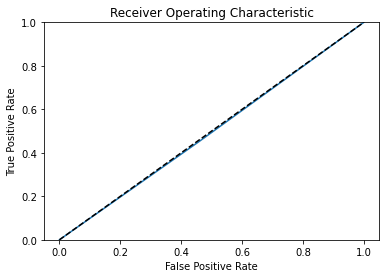

In [14]:
def find_best_tree_model(upper_depth, upper_leaf):
    best_model = None
    best_f1 = -1
    
    for depth in range(1, upper_depth + 1):
        for leaf in range(1, upper_leaf + 1):
            model = DecisionTreeClassifier(random_state=RANDOM_STATE, max_depth=depth, min_samples_leaf=leaf) 
            model.fit(X_train, y_train)
            y_pred = model.predict(X_val)
            
            f1 = f1_score(y_val, y_pred)
            
            if f1 > best_f1:
                best_f1 = f1
                best_model = model
    
    return best_model

best_tree_model = find_best_tree_model(50, 30)

run_model(best_tree_model)

## Random Forest

AUC is:  0.6573426573426573
              precision    recall  f1-score   support

           0       0.80      0.77      0.78        26
           1       0.50      0.55      0.52        11

    accuracy                           0.70        37
   macro avg       0.65      0.66      0.65        37
weighted avg       0.71      0.70      0.71        37

Confusion Matrix: 
 [[20  6]
 [ 5  6]]


RandomForestClassifier(n_estimators=50, random_state=42)

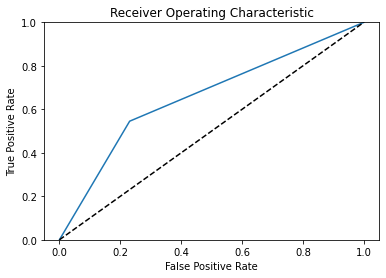

In [15]:
def find_best_forest_model(n_estimators):
    best_model = None
    best_f1 = -1
    
    for estimator in range(1, n_estimators + 1):
        model = RandomForestClassifier(random_state=RANDOM_STATE, n_estimators=n_estimators) 
        model.fit(X_train, y_train)
        y_pred = model.predict(X_val)

        f1 = f1_score(y_val, y_pred)

        if f1 > best_f1:
            best_f1 = f1
            best_model = model
    
    return best_model

best_forest_model = find_best_forest_model(50)

run_model(best_forest_model)

## SVM with grid search

Fitting 10 folds for each of 18 candidates, totalling 180 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  68 tasks      | elapsed:    2.4s


AUC is:  0.6066433566433566
              precision    recall  f1-score   support

           0       0.79      0.58      0.67        26
           1       0.39      0.64      0.48        11

    accuracy                           0.59        37
   macro avg       0.59      0.61      0.57        37
weighted avg       0.67      0.59      0.61        37

Confusion Matrix: 
 [[15 11]
 [ 4  7]]
Best SVM parameters: {'C': 10, 'degree': 3, 'kernel': 'poly'}


[Parallel(n_jobs=4)]: Done 180 out of 180 | elapsed:    2.7s finished


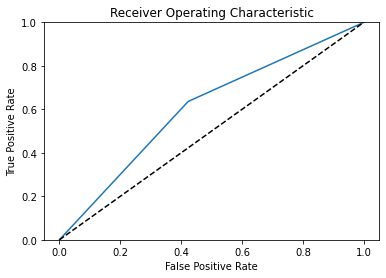

In [16]:
tuned_parameters = [{'kernel': ['rbf'], 'gamma': [1e-3, 1e-4], 'C': [1, 10, 100]},
                    {'kernel': ['poly'], 'degree': [3, 4, 5], 'C': [1, 10, 100]},
                    {'kernel': ['linear'], 'C': [1, 10, 100]}]

svm_model_cv = GridSearchCV(SVC(), tuned_parameters, cv=10, scoring='f1', verbose=1, n_jobs=4)

best_svm_model = run_model(svm_model_cv)
print(f"Best SVM parameters: {best_svm_model.best_params_}")

## Naive Neural Networks

In [17]:
model_name = "pretrained_word2vec_naive"

naive_model = Sequential()

naive_model.add(Dense(200, input_dim=X.shape[1], activation='relu'))
naive_model.add(Dense(100))
naive_model.add(Dense(1, bias_initializer=Constant(0.01), activation="sigmoid"))

print(naive_model.summary())
#plot_model(lstm_model, to_file=f'{model_name}.png', show_shapes=True)

train_NN(naive_model, model_name)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 200)               60200     
_________________________________________________________________
dense_2 (Dense)              (None, 100)               20100     
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 101       
Total params: 80,401
Trainable params: 80,401
Non-trainable params: 0
_________________________________________________________________
None
Train on 70 samples, validate on 18 samples
Epoch 1/50
70/70 [==============================] - 1s 8ms/step - loss: 0.6992 - accuracy: 0.4857 - val_loss: 0.6997 - val_accuracy: 0.4444
 — val_f1: 0.0 — val_precision: 0.0 — val_recall: 0.0
Epoch 2/50
70/70 [==============================] - 0s 167us/step - loss: 0.6935 - accuracy: 0.5143 - val_loss: 0.7097 - val_accuracy: 0.

/opt/conda/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


70/70 [==============================] - 0s 148us/step - loss: 0.6638 - accuracy: 0.6571 - val_loss: 0.7166 - val_accuracy: 0.3889
 — val_f1: 0.0 — val_precision: 0.0 — val_recall: 0.0
Epoch 11/50
70/70 [==============================] - 0s 128us/step - loss: 0.6638 - accuracy: 0.5714 - val_loss: 0.7247 - val_accuracy: 0.4444
 — val_f1: 0.0 — val_precision: 0.0 — val_recall: 0.0
Epoch 12/50
70/70 [==============================] - 0s 132us/step - loss: 0.6568 - accuracy: 0.6000 - val_loss: 0.7145 - val_accuracy: 0.3889
 — val_f1: 0.5217391304347826 — val_precision: 0.46153846153846156 — val_recall: 0.6
Epoch 13/50
70/70 [==============================] - 0s 143us/step - loss: 0.6467 - accuracy: 0.7000 - val_loss: 0.7163 - val_accuracy: 0.5556
 — val_f1: 0.7142857142857143 — val_precision: 0.5555555555555556 — val_recall: 1.0
Epoch 14/50
70/70 [==============================] - 0s 159us/step - loss: 0.6658 - accuracy: 0.6143 - val_loss: 0.7287 - val_accuracy: 0.5556
 — val_f1: 0.7142857

70/70 [==============================] - 0s 142us/step - loss: 0.5039 - accuracy: 0.7857 - val_loss: 0.8485 - val_accuracy: 0.4444
 — val_f1: 0.6153846153846154 — val_precision: 0.5 — val_recall: 0.8
Epoch 48/50
70/70 [==============================] - 0s 135us/step - loss: 0.5620 - accuracy: 0.7286 - val_loss: 0.8997 - val_accuracy: 0.5000
 — val_f1: 0.6666666666666667 — val_precision: 0.5294117647058824 — val_recall: 0.9
Epoch 49/50
70/70 [==============================] - 0s 132us/step - loss: 0.5328 - accuracy: 0.7286 - val_loss: 0.8241 - val_accuracy: 0.4444
 — val_f1: 0.5454545454545454 — val_precision: 0.5 — val_recall: 0.6
Epoch 50/50
70/70 [==============================] - 0s 139us/step - loss: 0.5087 - accuracy: 0.7571 - val_loss: 0.8703 - val_accuracy: 0.4444
 — val_f1: 0.16666666666666669 — val_precision: 0.5 — val_recall: 0.1
37/37 [==============================] - 0s 94us/step
Test loss: 0.5717862473951804
Test accuracy: 0.7297297120094299


[0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 1]
[1 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0 1 1 0 0 0 0 0 1 1 1 1 1 0 0] 

AUC is:  0.5979020979020979
              precision    recall  f1-score   support

           0       0.75      0.92      0.83        26
           1       0.60      0.27      0.37        11

    accuracy                           0.73        37
   macro avg       0.68      0.60      0.60        37
weighted avg       0.71      0.73      0.69        37

Confusion Matrix: 
 [[24  2]
 [ 8  3]]


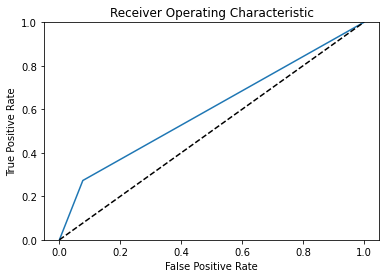

In [18]:
predictions = naive_model.predict(X_test)
y_pred = np.where(predictions > 0.5, 1, 0).flatten()

print(y_pred)
print(y_test.to_numpy(), '\n')

evaluate_on_training_set(y_test, y_pred)